# Workflow

In [25]:
what_we_covering = {1: "data (prepare and load)",
                    2: "build model",
                    3: "fitting the model to data (training)",
                    4: "making predictions and evaluating a model (inference)",
                    5: "saving and loading a model",
                    6: "putting it all together"}

In [26]:
import torch
from torch import nn # nn contains all of pytorch building blocks for neural networks
import matplotlib.pyplot as plt 
torch.__version__

'2.2.0+rocm5.7'

## 1. Data (preparing and loading)

Data can be almost anything in ML

* Excel
* imgs
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. get data into a numerical representation
2. build a model to learn patters in that numerical representation

We'll use a linear regression formula to make a straight line with know **parameters**.

In [27]:
# create know parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end, step).unsqueeze(dim=1) #vector unsqueezed into a matrix
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [28]:
# x is are input in tensor form, y is output
len(X),len(y)

(50, 50)

### Splitting data into traingin and test set
One of the most important steps in ML

In [29]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

In [30]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plots training data, test data and compares output
    """ 
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # predictions?
    if predictions is not None:
        # plot prediction if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show legend
    plt.legend(prop={"size":14});

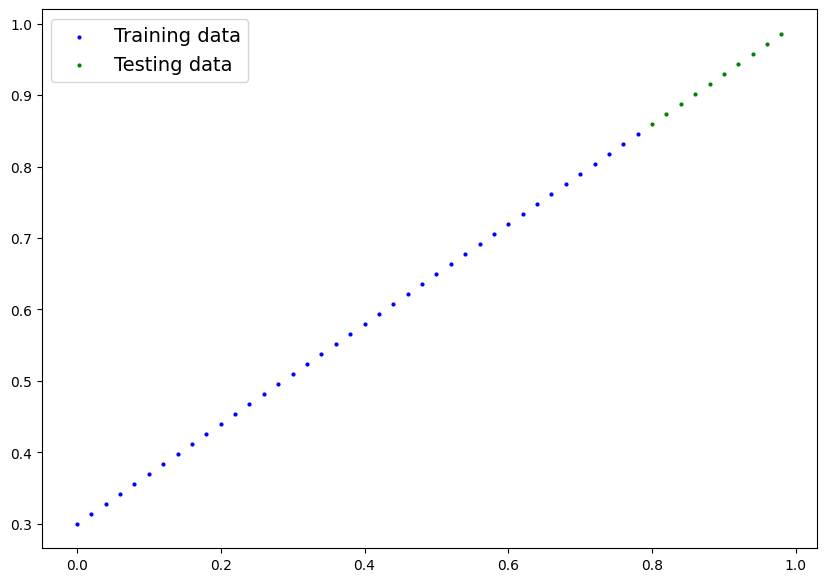

In [31]:
plot_predictions();

## 2. Build model

Our first pytorch model

What our model does:
* start with random values for weight and bias
* look at training data and adjusting to ideal values

How does it do so?

Through two main algos:
1. Gradient descent
2. Backpropagation

In [32]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): #<-everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is linear regression formula

### PyTorch model building essentials

* torch.nn - contains all the buidlings for computational graphs
* torch.nn.Parameter - what parameter should our model try and learn
* torch.nn.Module - the base class for all NN modules, if you subclass it, overwrite the forward() method
* torch.optim - this where the optimizers in pytoch live, they help gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method define what happens in foward computation

### Checking the conents of our pytorch model

Now we created a model, lets see what inside

We can checkout our model parameter or what inside our model using .parameters()

In [33]:
# Create a random see
torch.manual_seed(42)

# creat an instance of the model(subclass of nn.Module)
model_0 = LinearRegressionModel()

# checkout out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [34]:
# list name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, lets see how well it predicts `y_test` based on `X_test`

When we pass data throug our model, it run it through the forward() method

In [35]:
# make prediction with model
with torch.inference_mode(): #ignores grad fucntion
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

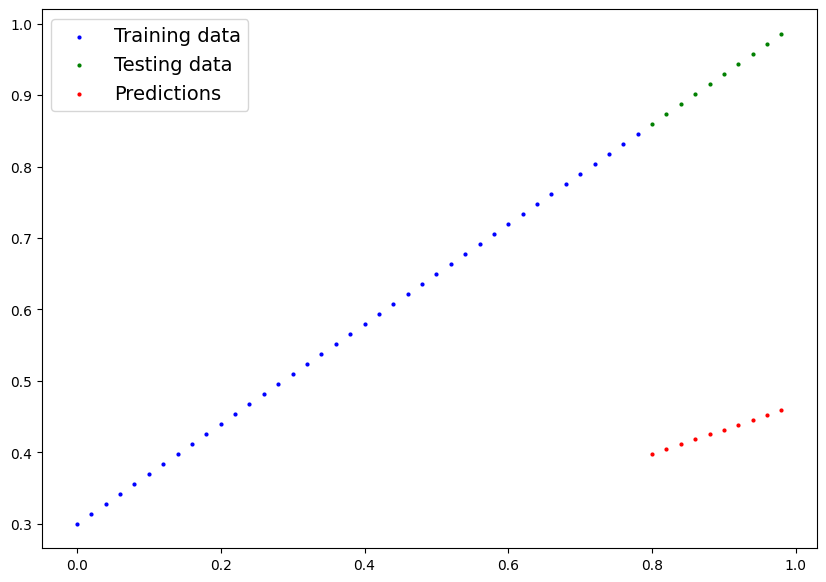

In [36]:
plot_predictions(predictions=y_preds)

## 3. Train model

Moving unknown parameters to some know parameters

Making a poor representation of the data to a better represenation of the data

One way to mearsure how poor or how wrong your models prediction is to use a loss function

* note: loss func may also be called cost func. We're going to refere to it as a loss func

Things we need to train:

* **Loss function:** A function to measure how wrong your models predection

* **Optimizer:** Takes into account the loss of a model and adjust the models parameters to improve loss function

    * Inside the optimizer you set two parameters:
        * **param** - model parameter you like to optimize
        * **lr** - the learning rate is a hyperparameter is how much the parameter changes

And specifically for pytorch, we need:
* a training loop
* a testing loop

In [37]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [38]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [39]:
# setup loss function
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparmeter you can set

### Building a training loop (and a testing loop) in pytorch

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving throgh our models `forward()` function) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to ajust our model parameters to try and improve the loss (**gradient descent**)

In [83]:
# An epoch is one loop through the data... (this is a hyperparameter)
torch.manual_seed(42)
epochs = 100

### Training
# 0. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in pytorch sets all parameter that require gradients to require gradient

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    #print(f"Loss: {loss}")

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculumate throgh the loop

    ### Testing
    model_0.eval() # turns off gradient tracking

    # print out model state_dict()
    #print(model_0.state_dict())

In [85]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [76]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

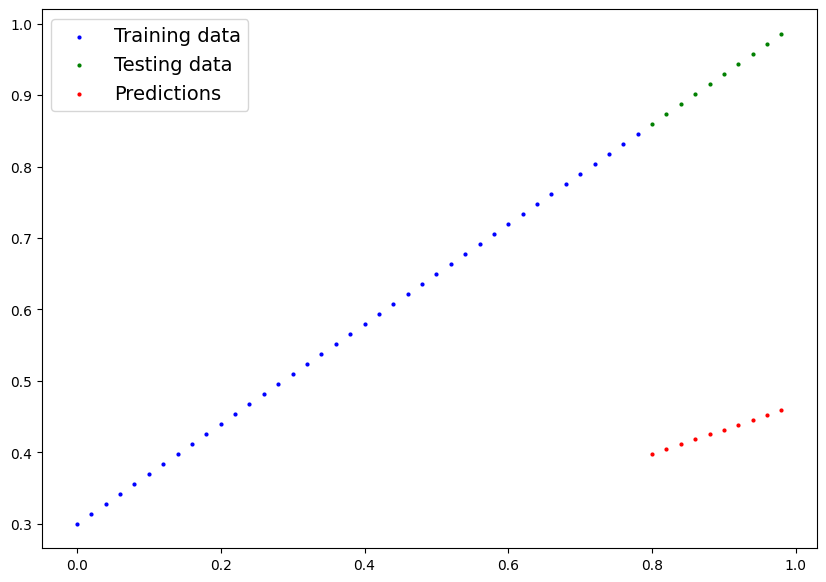

In [86]:
plot_predictions(predictions=y_preds)

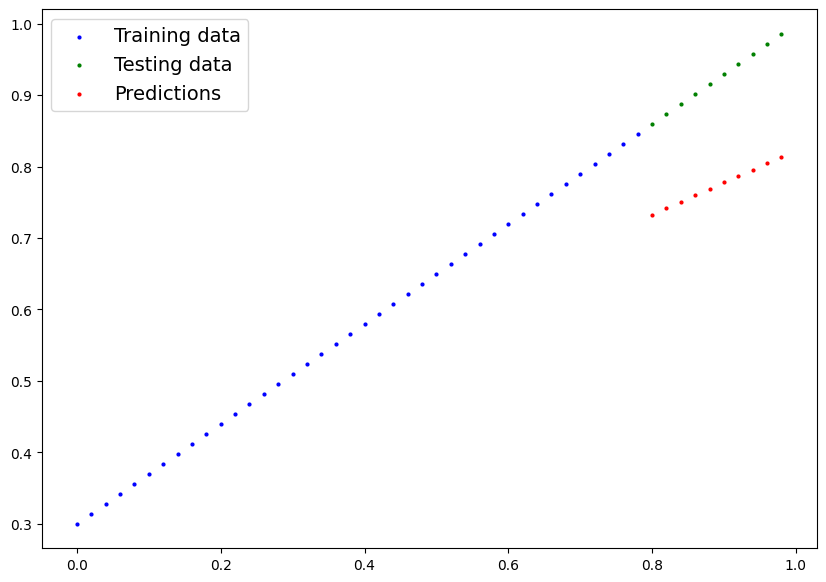

In [87]:
plot_predictions(predictions=y_preds_new)